# VAE with Gluon.probability 

In this notebook, we will demonstrate how you can implement a Variational Auto-encoder(VAE) with Gluon.probability and MXNet's latest NumPy API.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
import matplotlib.pyplot as plt

npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)

## Dataset

We will use MNIST here for simplicity purpose.

In [2]:
def load_data(batch_size):
    mnist_train = gluon.data.vision.MNIST(train=True)
    mnist_test = gluon.data.vision.MNIST(train=False)
    num_worker = 4
    transformer = gluon.data.vision.transforms.ToTensor()
    return (gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_worker),
          gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_worker))
                                 

## Model definition

In [4]:
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=256, n_latent=2, n_layers=1, n_output=784, act_type='relu', **kwargs):
        r"""
        n_hidden : number of hidden units in each layer
        n_latent : dimension of the latent space
        n_layers : number of layers in the encoder and decoder network
        n_output : dimension of the observed data
        """
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        self.encoder = nn.HybridSequential()
        for _ in range(n_layers):
            self.encoder.add(nn.Dense(n_hidden, activation=act_type))
        self.encoder.add(nn.Dense(n_latent*2, activation=None))
        self.decoder = nn.HybridSequential()
        for _ in range(n_layers):
            self.decoder.add(nn.Dense(n_hidden, activation=act_type))
        self.decoder.add(nn.Dense(n_output, activation='sigmoid'))
        
    def encode(self, x):
        r"""
        Given a batch of x,
        return the encoder's output
        """
        h = self.encoder(x)
        loc_scale = np.split(h, 2, 1)
        loc = loc_scale[0]
        log_variance = loc_scale[1]
        scale = np.exp(0.5 * log_variance)
        self.loc = loc
        return mgp.Normal(loc, scale)
    
    def decode(self, z):
        r"""
        Given a batch of samples from z,
        return the decoder's output
        """
        return self.decoder(z)

    def forward(self, x):
        r"""
        Given a batch of data x,
        return the negative of Evidence Lower-bound,
        i.e. an objective to minimize.
        """
        # prior p(z)
        pz = mgp.Normal(0, 1)
        
        # posterior q(z|x)
        qz_x = self.encode(x) 
        
        # Sampling operation qz_x.sample() is automatically reparameterized.
        z = qz_x.sample() 

        # Reconstruction result
        y = self.decode(z) 
        
        # Gluon.probability can help you calculate the analytical kl-divergence
        # between two distribution objects.
        KL = mgp.kl_divergence(qz_x, pz).sum(1)
        
        # We assume p(x|z) ~ Bernoulli, therefore we compute the reconstruction
        # loss with binary cross entropy.
        logloss = np.sum(x * np.log(y + self.soft_zero) + (1 - x)
                         * np.log(1 - y + self.soft_zero), axis=1)
        loss = -logloss + KL
        return loss

## Training

In [7]:
def train(net, n_epoch, print_period, train_iter, test_iter):
    net.initialize(mx.init.Xavier(), ctx=model_ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                          {'learning_rate': .001})
    training_loss = []
    validation_loss = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        epoch_val_loss = 0

        n_batch_train = 0
        for batch in train_iter:
            n_batch_train += 1
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            with autograd.record():
                loss = net(data)
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += np.mean(loss)

        n_batch_val = 0
        for batch in test_iter:
            n_batch_val += 1
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            loss = net(data)
            epoch_val_loss += np.mean(loss)

        epoch_loss /= n_batch_train
        epoch_val_loss /= n_batch_val

        training_loss.append(epoch_loss)
        validation_loss.append(epoch_val_loss)

        if epoch % max(print_period, 1) == 0:
            print('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(
              epoch, float(epoch_loss), float(epoch_val_loss)))

In [8]:
n_hidden = 128
n_latent = 40
n_layers = 3
n_output = 784
batch_size = 128
model_prefix = 'vae_gluon_{}d{}l{}h.params'.format(
  n_latent, n_layers, n_hidden)
net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers,
        n_output=n_output)
net.hybridize()
n_epoch = 50
print_period = n_epoch // 10
train_set, test_set = load_data(batch_size)
train(net, n_epoch, print_period, train_set, test_set)

Epoch0, Training loss 198.47, Validation loss 165.42
Epoch5, Training loss 121.50, Validation loss 120.12
Epoch10, Training loss 114.81, Validation loss 113.73
Epoch15, Training loss 111.33, Validation loss 110.75
Epoch20, Training loss 109.57, Validation loss 109.62
Epoch25, Training loss 108.31, Validation loss 108.14
Epoch30, Training loss 107.21, Validation loss 107.25
Epoch35, Training loss 106.17, Validation loss 106.22
Epoch40, Training loss 105.49, Validation loss 106.11
Epoch45, Training loss 104.90, Validation loss 105.22


## Reconstruction visualiztion

To verify the effictiveness of our model, we first take a look at how well our model can reconstruct the data.

In [9]:
# Grab a batch from the test set
qz_x = None
for batch in test_set:
    data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
    qz_x = net.encode(data)
    break

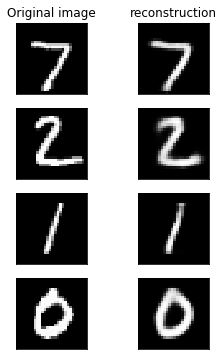

In [32]:
num_samples = 4
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(4, 6), subplot_kw={'xticks': [], 'yticks': []})
axes[0, 0].set_title('Original image')
axes[0, 1].set_title('reconstruction')
for i in range(num_samples):
    axes[i, 0].imshow(data[i].squeeze().reshape(28, 28).asnumpy(), cmap='gray')
    axes[i, 1].imshow(net.decode(qz_x.sample())[i].reshape(28, 28).asnumpy(), cmap='gray')

## Sample generation

One of the most important difference between Variational Auto-encoder and Auto-encoder is VAE's capabilities of generating new samples.

To achieve that, one simply needs to feed a random sample from $p(z) \sim \mathcal{N}(0,1)$ to the decoder network.

In [34]:
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

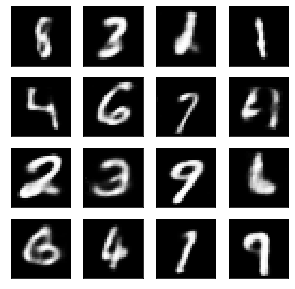

In [35]:
n_samples = 16
noise = np.random.randn(n_samples, n_latent).as_in_context(model_ctx)
dec_output = net.decode(noise).reshape(-1, 28, 28).asnumpy()
plot_samples(dec_output, 4, 4)